# Lung inflammation v4 - ResNet34

This notebook uses the [dataset](https://osf.io/28qbc/) from the publication "[Deep neural network based histological scoring of lung fibrosis and inflammation in the mouse model system](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0202708)" to train an CNN based on a ResNet34 to characterize inflammatory lung diseases from sections of lung tissue.<br><br>

**Publication benchmark:**<br>
Model: Inception V3, pretrained on ImageNet<br>
Accuracy: 0.80 (80%).<br><br>


<font color='blue'>**Notebook results:**<br>
Model: ResNet34, pretrained on ImageNet<br>
Data: training and validation data were used as in the provided dataset<br>
Training: image size of 224 for stage 1 and 2;<br>
stage 1: training of new network head;<br>
stage 2: training of the entire network with discriminative learning rates;<br>
Accuracy: 0.83 (83%).<br><br>
    
**Summary:**<br>In this notebook it could be shown that state-of-the-art results published August 23 2018 could be  improved with a smaller model.

## Notebook setup

In [1]:
## notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai
from fastai import *
from fastai.vision import *

In [3]:
# set path
path = Path('/home/paperspace/fastai/data/lung'); path

PosixPath('/home/paperspace/fastai/data/lung')

## Setup data and model (stage 1 and 2)

### Data setup

In [4]:
# set batchsize and image size for network
bs = 256
size = 224

In [5]:
# different transformations (the increase of the max_rotate parameter is crucial to improve the performance)
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0, max_warp=0.2) #1
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=45, max_zoom=1.1, max_lighting=0.1, max_warp=0.2) #2
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_zoom=1.1, max_lighting=0.2, max_warp=0.2) #3

In [102]:
# setup data with fastai data block API (https://docs.fast.ai/data_block.html)
data = (ImageFileList.from_folder(path/'lung_inflammation', extensions='.png')\
        .label_from_folder() # get labels from folders\
        .split_by_folder() # split dataset by train/valid folders\
        .datasets(ImageClassificationDataset) # creat image classification dataset\
        .transform(tfms, size=size) # apply transformations and resize images\
        .databunch(bs=bs)) # creat databunch with bs

In [103]:
# normaliez data with ImagNet statistics
data.normalize(imagenet_stats);

In [8]:
# print class names, number of class, length of train dataset, and length of valid dataset
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '2', '3', 'ignore', '1'], 5, 3974, 726)

### Model setup

A ResNet34 is setup with pretrained weights from Imagenet with a custom head, i.e. the final layers specific for ImageNet classification are removed and replaced by final layers suitable for our 5 classes.

In [9]:
!gpustat --no-header

[0] Quadro P4000     | 35'C,   0 % |    10 /  8119 MB |


In [10]:
# create learner for mixed precision training, from https://docs.fast.ai/callbacks.fp16.html
learn = create_cnn(data, models.resnet34, metrics=accuracy).to_fp16()

In [11]:
# add save SaveModelCallback to save the model weights for every epoch
learn.callback_fns.append(partial(SaveModelCallback, every='epoch', name='lung_inf_v4-ResNet34_stage-X_train-Y_epoch'))

In [12]:
#learn.callback_fns.append(partial(ReduceLROnPlateauCallback, patience=0, factor=0.2, min_delta=0))

In [13]:
learn.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lung_inf_v4-ResNet34_stage-X_train-Y_epoch')]

In [14]:
!gpustat --no-header

[0] Quadro P4000     | 36'C,   0 % |   599 /  8119 MB | paperspace(589M)


## Training (stage 1 and 2)

### Stage 1 - Training of new head

In stage 1 only the new head of the network is trained and rest is frozen.

In [ ]:
# loss vs learning rate vs batch size see: https://miguel-data-sc.github.io/2017-11-05-first/

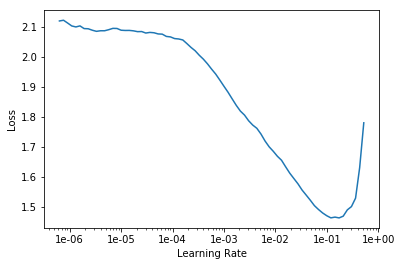

In [56]:
# find learning rate at the highest negative slope at the loss vs. learning rate plot
learn.lr_find()
learn.recorder.plot()

In [57]:
!gpustat --no-header

[0] Quadro P4000     | 53'C,   0 % |  6131 /  8119 MB | paperspace(6121M)


In [24]:
# find optimal weight decay parameter
# from https://github.com/DrHB/fastai_wd/blob/master/wd_example.ipynb

@dataclass  
class wd_finder:
    #learner
    #wd, can be a single value or a tuple
    # if no wd is passed it will use standard wds 
    
    learn: Learner
    wd:Union[int,Callable]=None
    
    def __post_init__(self, **kwargs):
        self.wd_list = listify(self.wd)
        self.wd_recorder = []
        
        if self.wd is None:
            self.wd_list = [0, 1e-1, 1e-3, 1e-5]
            
        for wd in self.wd_list:
            self.learn.lr_find(wd=self.wd, **kwargs)
            self.wd_recorder.append(self.learn.recorder)
            
    def plot_wd(self, skip_start:int=10, skip_end:int=5)->None:
        _, ax = plt.subplots(1,1)
        
        for k, i in enumerate(self.wd_recorder):
            losses = i.losses[skip_start:-skip_end] if skip_end > 0 else i.losses[skip_start:]
            lrs = i.lrs[skip_start:-skip_end] if skip_end > 0 else i.lrs[skip_start:]
            ax.plot(lrs, losses, label='wd = {}'.format(self.wd_list[k]))
            ax.legend()
            ax.set_xscale('log')

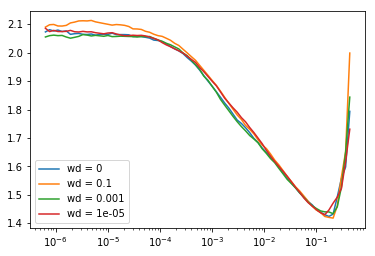

In [60]:
find_wd = wd_finder(learn)
find_wd.plot_wd()

In [12]:
wd = 0.1

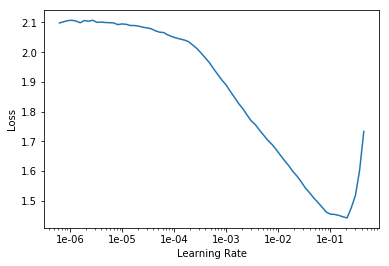

In [64]:
# verify selected weight decay parameter
learn.lr_find(wd=wd)
learn.recorder.plot()

In [13]:
lr = 3e-2

In [14]:
# check learning rate and weight decay parameter
lr, wd

(0.03, 0.1)

In [17]:
learn.fit_one_cycle(12, max_lr=lr, wd=wd)

Total time: 08:08
epoch  train_loss  valid_loss  accuracy
1      1.171358    1.486663    0.465565  (00:43)
2      0.952546    0.949012    0.677686  (00:40)
3      0.844680    1.981664    0.409091  (00:40)
4      0.786021    0.993940    0.646006  (00:37)
5      0.756003    1.464196    0.574380  (00:37)
6      0.720755    0.706838    0.739669  (00:38)
7      0.690531    0.603017    0.761708  (00:37)
8      0.659128    0.560833    0.782369  (00:42)
9      0.630102    0.504796    0.800276  (00:44)
10     0.602659    0.484392    0.814050  (00:44)
11     0.575208    0.465513    0.826446  (00:41)
12     0.553901    0.459801    0.823691  (00:38)



In [20]:
# load weights from epoch 11 with an accuracy of 0.826446
learn.load('lung_inf_v4-ResNet34_stage-1_train-1_epoch-11_0-826446')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


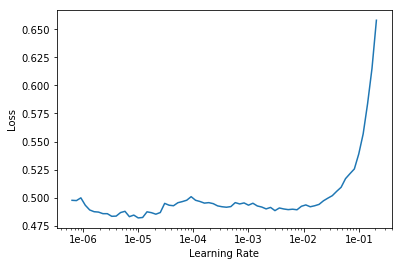

In [13]:
# verify learning rate parameter
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 1e-3
wd = 0.1 # from above

In [21]:
learn.fit_one_cycle(6, max_lr=lr, wd=wd)

Total time: 04:12
epoch  train_loss  valid_loss  accuracy
1      0.503887    0.459425    0.826446  (00:45)
2      0.490035    0.461132    0.818182  (00:44)
3      0.487433    0.463127    0.816804  (00:43)
4      0.489946    0.462316    0.827824  (00:41)
5      0.483916    0.459791    0.830579  (00:38)
6      0.483690    0.458630    0.830579  (00:39)



In [22]:
learn.load('lung_inf_v4-ResNet34_stage-1_train-2_epoch-6_0-830579')

<font color=blue>**Conclusion stage 1 - Training of new head:**<br>
Training only the the new last layers from the new head (and keeping the rest of the network frozen) enabled the network to achieve a accuracy of approx. 0.83 (83%) after 18 epochs. This already improved the published accuracy benchmark!

### Stage 2 - Training of the entire network

In stage 2 the entire network is trained with discriminative learning rates, i.e. lower learning rates for the earyl layers and higher learning rates for the late layers.

In [14]:
!gpustat --no-header

[0] Quadro P4000     | 44'C,   0 % |   599 /  8119 MB | paperspace(589M)


In [15]:
learn.load('lung_inf_v4-ResNet34_stage-1_train-2_epoch-6_0-830579')

In [16]:
# reduce learning rate callback when hitting plateau
learn.callback_fns.append(partial(ReduceLROnPlateauCallback, patience=0, factor=0.2, min_delta=0))

In [17]:
learn.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lung_inf_v4-ResNet34_stage-X_train-Y_epoch'),
 functools.partial(<class 'fastai.callbacks.tracker.ReduceLROnPlateauCallback'>, patience=0, factor=0.2, min_delta=0)]

In [18]:
learn.unfreeze()

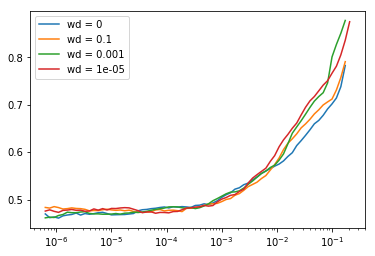

In [26]:
find_wd = wd_finder(learn)
find_wd.plot_wd()

In [19]:
max_lr = 1e-5
wd = 0

In [20]:
!gpustat --no-header

[0] Quadro P4000     | 42'C,   0 % |   599 /  8119 MB | paperspace(589M)


In [21]:
learn.fit_one_cycle(12, max_lr=slice(1e-6, max_lr))

Total time: 09:37
epoch  train_loss  valid_loss  accuracy
1      0.475294    0.457470    0.833333  (00:58)
2      0.483069    0.456876    0.833333  (00:50)
3      0.478316    0.454964    0.829201  (00:45)
4      0.474562    0.457965    0.827824  (00:47)
5      0.473054    0.454866    0.831956  (00:45)
6      0.470086    0.455263    0.829201  (00:44)
7      0.473406    0.455355    0.827824  (00:48)
8      0.472048    0.454589    0.829201  (00:47)
9      0.471958    0.455114    0.827824  (00:50)
10     0.471716    0.454902    0.827824  (00:46)
11     0.470670    0.455500    0.827824  (00:45)
12     0.465082    0.453987    0.830579  (00:46)



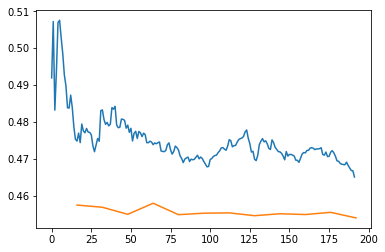

In [22]:
learn.recorder.plot_losses()

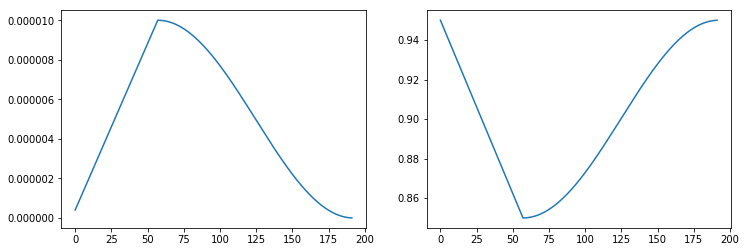

In [23]:
learn.recorder.plot_lr(show_moms=True)

### Predictions

In [104]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [105]:
learn.load('lung_inf_v4-ResNet34_stage-2_train-3_epoch-2_0-833333')

In [68]:
# set model to float32 again for prediction
learn.model.float() # better use brackets: https://discuss.pytorch.org/t/how-to-cast-a-tensor-to-another-type/2713/7

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [89]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [106]:
# check data type of first module with weights
learn.model[0][0], learn.model[0][0].weight.type()

(Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 'torch.cuda.FloatTensor')

In [107]:
# check data type of last module with weights
learn.model[1][4], learn.model[1][4].weight.type()

(Linear(in_features=1024, out_features=512, bias=True),
 'torch.cuda.FloatTensor')

In [108]:
learn.get_preds()

[tensor([[0.7337, 0.0799, 0.0188, 0.0178, 0.1499],
         [0.9979, 0.0000, 0.0000, 0.0008, 0.0012],
         [0.8008, 0.0144, 0.0045, 0.1259, 0.0545],
         ...,
         [0.2213, 0.3742, 0.1190, 0.0769, 0.2086],
         [0.0053, 0.7520, 0.0537, 0.0004, 0.1886],
         [0.1370, 0.0602, 0.0015, 0.0009, 0.8003]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 

In [109]:
# check validation set loss and accuracy
#learn.validate(data.valid_dl.add_tfm(to_half)) # mixed precision weights work with this!
learn.validate()

[0.45689973, tensor(0.8320)]

In [110]:
#learn.TTA(data.valid_dl.add_tfm(to_half)) # mixed precision weights do not work with this
learn.TTA()

Total time: 01:55



(tensor([[0.6497, 0.1281, 0.0316, 0.0353, 0.1554],
         [0.9298, 0.0026, 0.0003, 0.0034, 0.0638],
         [0.7184, 0.0576, 0.0118, 0.1102, 0.1020],
         ...,
         [0.1287, 0.3932, 0.2321, 0.0536, 0.1924],
         [0.0873, 0.3946, 0.0263, 0.0031, 0.4887],
         [0.3226, 0.0527, 0.0018, 0.0032, 0.6196]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 

<font color=blue>**Conclusion stage 2 - Training of the entire network:**<br>
The training of the entire network with discriminative learning rates was able to reduce the training loss and increase the accuracy slightly.

## Interpretation

In [111]:
interp = ClassificationInterpretation.from_learner(learn)

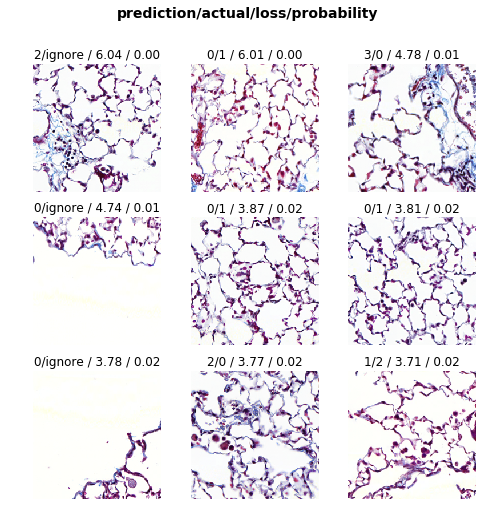

In [112]:
interp.plot_top_losses(9, figsize=(8,8))

In [113]:
interp.confusion_matrix()

array([[253,   1,   1,   7,  14],
       [  1,  43,   7,   1,  23],
       [  0,   7,  60,   2,   1],
       [ 14,   3,   2, 176,   1],
       [ 20,  15,   1,   1,  72]])

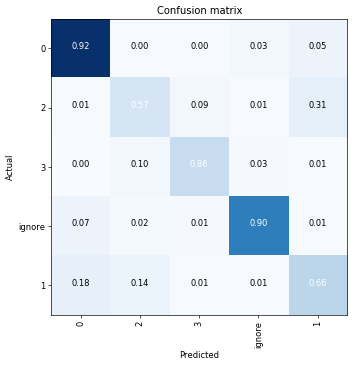

In [114]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60, normalize=True)